In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowers-dataset/sample_submission.csv
/kaggle/input/flowers-dataset/Testing_set_flower.csv
/kaggle/input/flowers-dataset/LICENSE.txt
/kaggle/input/flowers-dataset/test/Image_747.jpg
/kaggle/input/flowers-dataset/test/Image_561.jpg
/kaggle/input/flowers-dataset/test/Image_345.jpg
/kaggle/input/flowers-dataset/test/Image_844.jpg
/kaggle/input/flowers-dataset/test/Image_270.jpg
/kaggle/input/flowers-dataset/test/Image_526.jpg
/kaggle/input/flowers-dataset/test/Image_322.jpg
/kaggle/input/flowers-dataset/test/Image_860.jpg
/kaggle/input/flowers-dataset/test/Image_574.jpg
/kaggle/input/flowers-dataset/test/Image_879.jpg
/kaggle/input/flowers-dataset/test/Image_22.jpg
/kaggle/input/flowers-dataset/test/Image_486.jpg
/kaggle/input/flowers-dataset/test/Image_608.jpg
/kaggle/input/flowers-dataset/test/Image_592.jpg
/kaggle/input/flowers-dataset/test/Image_352.jpg
/kaggle/input/flowers-dataset/test/Image_687.jpg
/kaggle/input/flowers-dataset/test/Image_278.jpg
/kaggle/input/flowers

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

2025-10-03 12:06:12.225503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759493172.460087      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759493172.531160      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/input/flowers-dataset/sample_submission.csv')
df.head()

,prediction
0,sunflower
1,sunflower
2,sunflower
3,sunflower
4,sunflower


In [5]:
df.columns

Index(['prediction'], dtype='object')

In [6]:
# Dataset path
train_path = '/kaggle/input/flowers-dataset/train'

# Show class names
class_names = sorted(os.listdir(train_path))
print("Classes:", class_names)

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


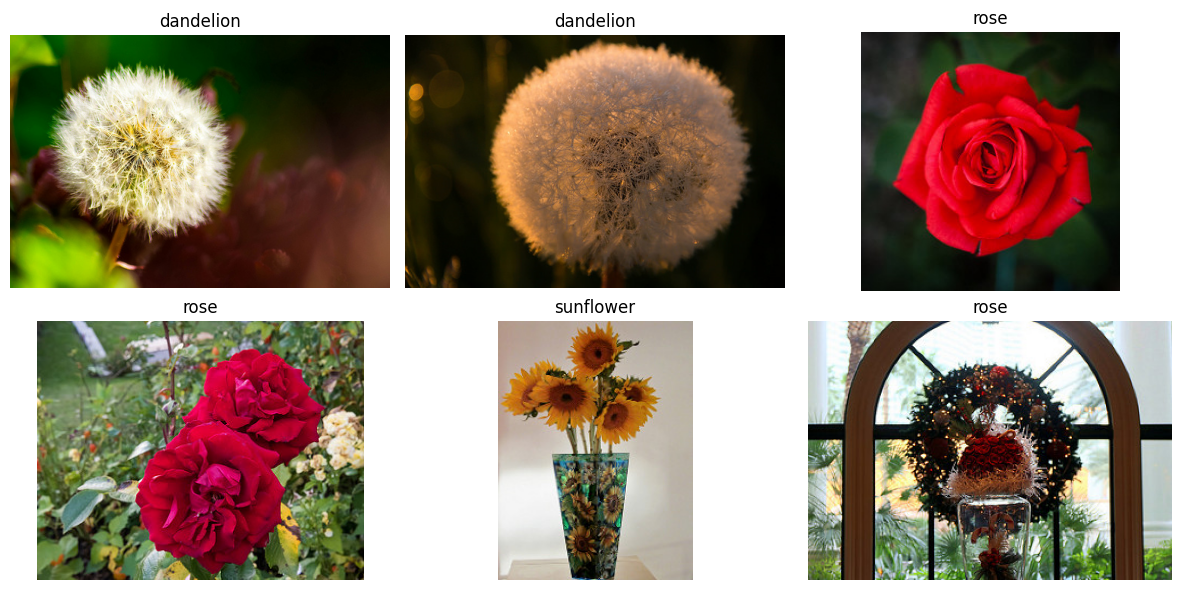

In [7]:
import matplotlib.image as mpimg
import random

plt.figure(figsize=(12, 6))
for i in range(6):
    class_name = random.choice(class_names)
    img_name = random.choice(os.listdir(os.path.join(train_path, class_name)))
    img_path = os.path.join(train_path, class_name, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [9]:
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze weights

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-10-03 12:06:30.332741: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.2011 - loss: 1.6694 - val_accuracy: 0.2354 - val_loss: 1.6131
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.2168 - loss: 1.6132 - val_accuracy: 0.2354 - val_loss: 1.6034
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.2288 - loss: 1.6107 - val_accuracy: 0.2354 - val_loss: 1.6058
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.2367 - loss: 1.6060 - val_accuracy: 0.2354 - val_loss: 1.6031
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.2258 - loss: 1.6066 - val_accuracy: 0.2354 - val_loss: 1.6029


18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00       100
   dandelion       0.24      1.00      0.38       129
        rose       0.00      0.00      0.00        99
   sunflower       0.00      0.00      0.00        99
       tulip       0.00      0.00      0.00       121

    accuracy                           0.24       548
   macro avg       0.05      0.20      0.08       548
weighted avg       0.06      0.24      0.09       548



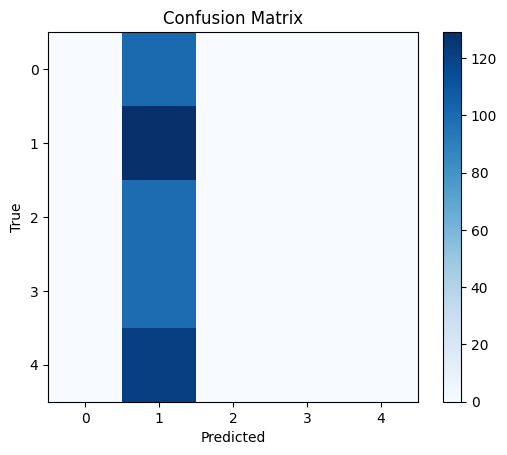

In [11]:
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

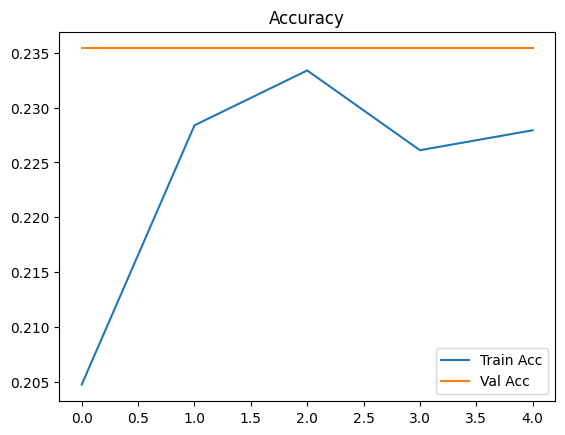

In [12]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()